In [1]:
from tensorflow import keras
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
import numpy as np

In [2]:
# importe de pacotes
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False,
                        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # the shortcut branch of the ResNet module should be
        # initialize as the input (identity) data
        shortcut = data

        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
                       kernel_regularizer=l2(reg))(act1)

        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
                       padding="same", use_bias=False,
                       kernel_regularizer=l2(reg))(act2)

        # the third block of the ResNet module is another set of 1x1
        # CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
                                 momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False,
                       kernel_regularizer=l2(reg))(act3)

        # if we are to reduce the spatial size, apply a CONV layer to
        # the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride,
                              use_bias=False, kernel_regularizer=l2(reg))(act1)

        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])

        # return the addition as the output of the ResNet module
        return x

    @staticmethod
    def build(width, height, depth, classes, stages, filters,
              reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # set the input and apply BN
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(inputs)

        # apply CONV => BN => ACT => POOL to reduce spatial size
        x = Conv2D(filters[0], (5, 5), use_bias=False,
                   padding="same", kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = ZeroPadding2D((1, 1))(x)
        x = MaxPooling2D((3, 3), strides=(2, 2))(x)

        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                                       chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                                           (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                               momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)

        # sigmoid classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("sigmoid")(x)

        # create the model
        model = Model(inputs, x, name="resnet")

        # return the constructed network architecture
        return model


In [3]:
height, width = 512, 512

In [4]:
# initialize the number of training epochs and batch size
NUM_EPOCHS = 50
BS = 8
TRAIN_PATH = '../dados/'
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(TRAIN_PATH)))

In [5]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    validation_split=0.1)

In [6]:

# initialize the testing data augmentation object
testAug = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.1)

In [7]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(height, width),
    color_mode="rgb",
    shuffle=True,
    seed=123,
    batch_size=BS,
    subset='training')

Found 3200 images belonging to 2 classes.


In [8]:
# initialize the testing generator
testGen = testAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(height, width),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS,
    subset='validation')

Found 355 images belonging to 2 classes.


In [9]:
model = ResNet.build(height, width, 3, 2, (2, 2, 3),
                     (32, 64, 128, 256), reg=0.0005)

In [10]:
model.compile(loss="binary_crossentropy", 
              optimizer='Adam',
              metrics=["accuracy", 
                        keras.metrics.AUC(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall()])

In [11]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# train our Keras model
H = model.fit(
    trainGen,
    validation_data=testGen,
    epochs=NUM_EPOCHS)

Epoch 1/50
400/400 [==============================] - 421s 1s/step - loss: 0.4535 - accuracy: 0.8950 - auc: 0.9547 - precision: 0.8965 - recall: 0.8931 - val_loss: 0.4838 - val_accuracy: 0.8817 - val_auc: 0.9352 - val_precision: 0.8817 - val_recall: 0.8817
Epoch 2/50
400/400 [==============================] - 417s 1s/step - loss: 0.3393 - accuracy: 0.9287 - auc: 0.9752 - precision: 0.9299 - recall: 0.9287 - val_loss: 0.3122 - val_accuracy: 0.9380 - val_auc: 0.9794 - val_precision: 0.9380 - val_recall: 0.9380
Epoch 3/50
400/400 [==============================] - 417s 1s/step - loss: 0.2968 - accuracy: 0.9422 - auc: 0.9802 - precision: 0.9416 - recall: 0.9422 - val_loss: 0.4291 - val_accuracy: 0.8845 - val_auc: 0.9577 - val_precision: 0.8792 - val_recall: 0.8817
Epoch 4/50
400/400 [==============================] - 417s 1s/step - loss: 0.2698 - accuracy: 0.9444 - auc: 0.9827 - precision: 0.9441 - recall: 0.9453 - val_loss: 0.2743 - val_accuracy: 0.9380 - val_auc: 0.9781 - val_precision: 

dict_keys([&#39;loss&#39;, &#39;accuracy&#39;, &#39;auc&#39;, &#39;precision&#39;, &#39;recall&#39;, &#39;val_loss&#39;, &#39;val_accuracy&#39;, &#39;val_auc&#39;, &#39;val_precision&#39;, &#39;val_recall&#39;])

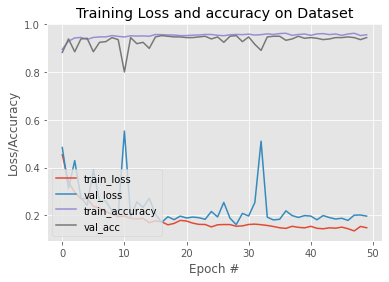

In [12]:
import matplotlib.pyplot as plt

N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('Training Loss and accuracy on Dataset')
H.history.keys()

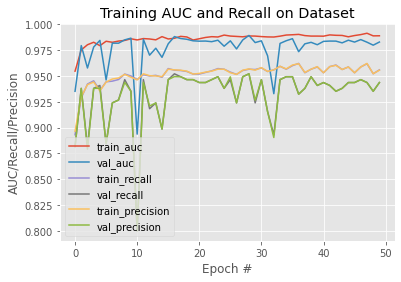

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.plot(np.arange(0, N), H.history["recall"], label="train_recall")
plt.plot(np.arange(0, N), H.history["val_recall"], label="val_recall")
plt.plot(np.arange(0, N), H.history["precision"], label="train_precision")
plt.plot(np.arange(0, N), H.history["val_precision"], label="val_precision")

plt.title("Training AUC and Recall on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("AUC/Recall/Precision")
plt.legend(loc="lower left")
plt.savefig('Training AUC, Recall and Precision on Dataset')

                    precision    recall  f1-score   support

rx-alterado-anonim       0.93      0.95      0.94       167
  rx-normal-anonim       0.96      0.94      0.95       188

          accuracy                           0.94       355
         macro avg       0.94      0.94      0.94       355
      weighted avg       0.94      0.94      0.94       355



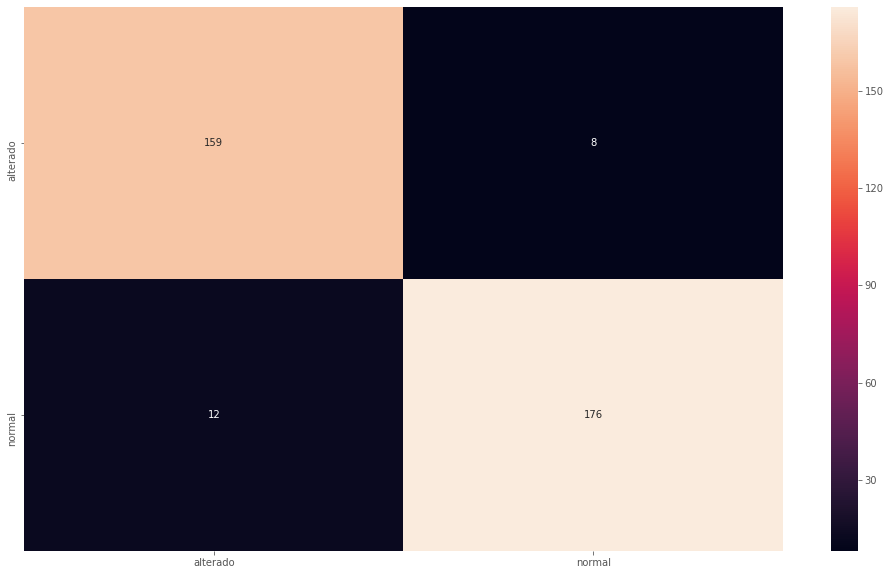

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

testGen.reset()
predIdxs = model.predict(testGen, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


conf_mat = confusion_matrix(testGen.classes, predIdxs)

class_names = ['alterado', 'normal']
fig = plt.figure(figsize=(17,10))
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
heatmap

# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
                            target_names=testGen.class_indices.keys()))


In [15]:
model.save('Models/H{}W{}.h5'.format(height, width))